In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/FastAI/

/content/drive/MyDrive/FastAI


In [ ]:
from fastai.vision.all import *
from fastai.callback.fp16 import *
from models.MDNet import *

print(torch.cuda.is_available())

True


In [ ]:
path = Path('./data/img/undersample_500')
path.ls()

(#9) [Path('data/img/undersample_500/9'),Path('data/img/undersample_500/3'),Path('data/img/undersample_500/2'),Path('data/img/undersample_500/4'),Path('data/img/undersample_500/1'),Path('data/img/undersample_500/7'),Path('data/img/undersample_500/5'),Path('data/img/undersample_500/8'),Path('data/img/undersample_500/6')]

## Dataset & Training

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 171MB/s]


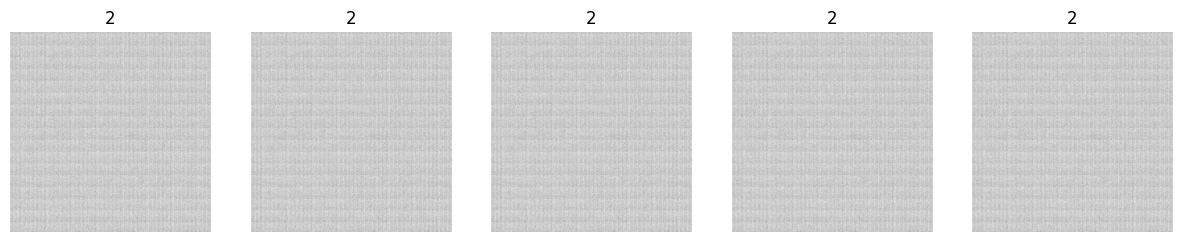

In [ ]:
# Data Block
data_block = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(1024, min_scale=0.50)
)

# Batch
dls = data_block.dataloaders(path, bs=32)

# Models : MDResNet-18/34, MDDenseNet-121 / 169
model = MDResNet18(pretrained=True)

dls.train.show_batch(max_n=5, nrows=1, unique=True)

In [ ]:
# Learner with Model-ResNet-18/34/50
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, error_rate]).to_fp16()

# Strategy : Find the optimal learning rate and Train
#learn.lr_find()

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.991983,1.206502,0.607918,0.392082,17:00
1,0.499183,0.936267,0.685824,0.314176,01:54
2,0.316455,0.938361,0.683270,0.316731,01:54
3,0.202752,1.535671,0.574713,0.425287,01:54
4,0.200977,1.418534,0.745849,0.254151,01:54
5,0.164969,0.828562,0.745849,0.254151,01:55
6,0.141068,1.040955,0.598978,0.401022,01:56
7,0.141041,0.684697,0.807152,0.192848,01:53
8,0.094545,0.610597,0.780332,0.219668,01:54
9,0.106008,0.565866,0.858238,0.141762,01:53


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

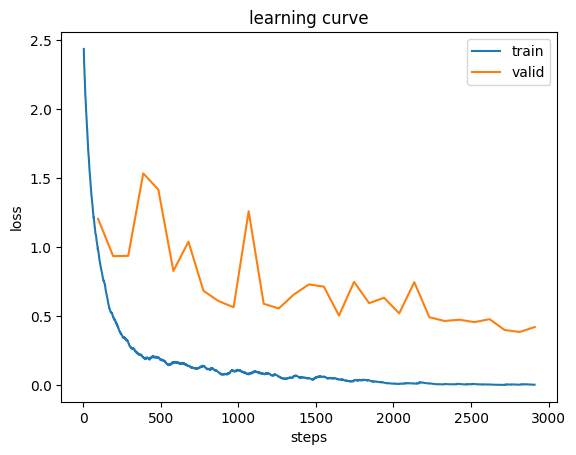

In [ ]:
lr_min = 3e-4
learn.fit_one_cycle(30, slice(lr_min))

# Best Acc : 0.8863 (28 epoch)
learn.recorder.plot_loss()
#learn.recorder.plot_metrics()